In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from openparticle import ParticleOperator
import numpy as np
import cirq
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../../..'))
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../..'))
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../'))
from src.lobe.asp import get_target_state, add_prepare_circuit
from pauli_lcu import lcuify, piecewise_lcu
from src.lobe.rescale import rescale_coefficients
from src.lobe.system import System
from colors import *
from openparticle import generate_matrix
from src.lobe._utils import get_basis_of_full_system
from src.lobe.bosonic import bosonic_product_block_encoding, bosonic_product_plus_hc_block_encoding
from src.lobe.fermionic import fermionic_product_block_encoding
from src.lobe.index import index_over_terms
from src.lobe.metrics import CircuitMetrics
from tests._utils import _validate_block_encoding
from functools import partial

/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-27 16:11:12,684	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
def static_yukawa_Hamiltonian(Cf = 1, Cb = 1, g = 1):
    return (
        Cf * ParticleOperator('b0^ b0') 
        + Cb * ParticleOperator('a0^ a0')
        + g * ParticleOperator('b0^ b0')  *(
            ParticleOperator('a0^') + ParticleOperator('a0')
        )
    )

In [4]:
def _blank_be_func(ctrls=([], [])):
    return [], CircuitMetrics()

def lobeify(operator, max_bosonic_occupancy):
    terms = operator.group()
    
    number_of_block_encoding_ancillae = 3
    index_register = [cirq.LineQubit(-i - 2) for i in range(int(np.ceil(np.log2(len(terms)))))]
    block_encoding_ancillae = [cirq.LineQubit(-100 - i - len(index_register)) for i in range(number_of_block_encoding_ancillae)]
    ctrls = ([cirq.LineQubit(0)], [1])
    clean_ancillae = [cirq.LineQubit(i + 100) for i in range(100)]
    number_of_fermionic_modes = 0
    number_of_bosonic_modes = 0
    if operator.max_fermionic_mode is not None:
        number_of_fermionic_modes = operator.max_fermionic_mode + 1
    if operator.max_bosonic_mode is not None:
        number_of_bosonic_modes = operator.max_bosonic_mode + 1
    system = System(
        max_bosonic_occupancy,
        1000,
        number_of_fermionic_modes=number_of_fermionic_modes,
        number_of_bosonic_modes=number_of_bosonic_modes,
    )
    
    block_encoding_functions = []
    rescaling_factors = []
    for term in terms:

        if term.has_identity():
            block_encoding_functions.append(_blank_be_func)
            rescaling_factors.append(1)
            continue
        
        if term == ParticleOperator("b0^ b0"):
            block_encoding_functions.append(
                partial(
                fermionic_product_block_encoding,
                    system=system,
                    block_encoding_ancillae=[block_encoding_ancillae[0]],
                    active_indices=[0],
                    operator_types=[2],
                    clean_ancillae=clean_ancillae[10:],
            ))
            rescaling_factors.append(1)
        elif term == ParticleOperator("a0^ a0"):
            block_encoding_functions.append(
                partial(
                    bosonic_product_block_encoding,
                    system=system,
                    block_encoding_ancillae=block_encoding_ancillae[0],
                    active_indices=[0],
                    exponents_list=[(1,1)],
                    clean_ancillae=clean_ancillae[10:],
            ))
            rescaling_factors.append(max_bosonic_occupancy)
        elif term == (ParticleOperator("b0^ b0 a0^") + ParticleOperator("b0^ b0 a0")):
            def _custom(ctrls=([], [])):
                gates, metrics = fermionic_product_block_encoding(
                    system=system,
                    block_encoding_ancillae=[block_encoding_ancillae[0]],
                    active_indices=[0],
                    operator_types=[2],
                    clean_ancillae=clean_ancillae[10:],
                    ctrls=ctrls
                )

                _gates, _metrics = bosonic_product_plus_hc_block_encoding(
                    system,
                    block_encoding_ancillae=block_encoding_ancillae[1:],
                    active_indices=[0],
                    exponents_list=[(1, 0)],
                    clean_ancillae=clean_ancillae[10:],
                    ctrls=ctrls
                )
                gates += _gates
                metrics += _metrics

                return gates, metrics

            block_encoding_functions.append(_custom)
            rescaling_factors.append(2*np.sqrt(max_bosonic_occupancy))
        else:
            raise RuntimeError("Term not expected: ", term)


    rescaled_coefficients, overall_rescaling_factor = rescale_coefficients(
        [term.coeffs[0] for term in terms],
        rescaling_factors
    )
    target_state = get_target_state(rescaled_coefficients)
    
    gates = []
    metrics = CircuitMetrics()

    gates.append(cirq.X.on(ctrls[0][0]))

    _gates, _metrics = add_prepare_circuit(index_register, target_state, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = index_over_terms(index_register, block_encoding_functions, clean_ancillae, ctrls=ctrls)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = add_prepare_circuit(index_register, target_state, dagger=True, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics

    gates.append(cirq.X.on(ctrls[0][0]))

    overall_rescaling_factor = sum([term.coeffs[0]*rescaling_factor for term, rescaling_factor in zip(terms, rescaling_factors)])
    circuit = cirq.Circuit(gates)

    _validate_block_encoding(circuit, system, overall_rescaling_factor, operator, len(index_register) + number_of_block_encoding_ancillae, max_bosonic_occupancy, max_qubits=16, using_pytest=False)

    return  metrics, overall_rescaling_factor, len(index_register) + number_of_block_encoding_ancillae, system.number_of_system_qubits

In [5]:
operator = static_yukawa_Hamiltonian().normal_order()
operator.remove_identity()

omegas = [1, 3, 7, 15, 31]

print("LCU")
LCU_DATA = [lcuify(operator, omega) for omega in omegas]
print("Piecewise Pauli")
PIECEWISE_DATA = [piecewise_lcu(operator, omega) for omega in omegas]
print("LOBE")
LOBE_DATA = [lobeify(operator, omega) for omega in omegas]

LCU
Testing singular quantum state for circuit with 14 qubits
Too many qubits to validate: 16
Piecewise Pauli
Testing singular quantum state for circuit with 14 qubits
Too many qubits to validate: 19
Too many qubits to validate: 22
Too many qubits to validate: 27
LOBE
Testing singular quantum state for circuit with 13 qubits
Testing singular quantum state for circuit with 15 qubits
Too many qubits to validate: 17
Too many qubits to validate: 19


In [6]:
operator = static_yukawa_Hamiltonian().normal_order()
operator.remove_identity()
operator_norms = []
for omega in omegas:
    full_fock_basis = get_basis_of_full_system(
        omega,
        operator.max_fermionic_mode + 1,
        operator.max_bosonic_mode + 1
    )
    expected_unitary = generate_matrix(operator, full_fock_basis)
    operator_norms.append(np.linalg.norm(expected_unitary, ord=2))
    print(omega, operator_norms[-1])

1 2.618033988749895
3 5.5442870335519805
7 10.913668183493792
15 20.920060734813525
31 39.84083125274357


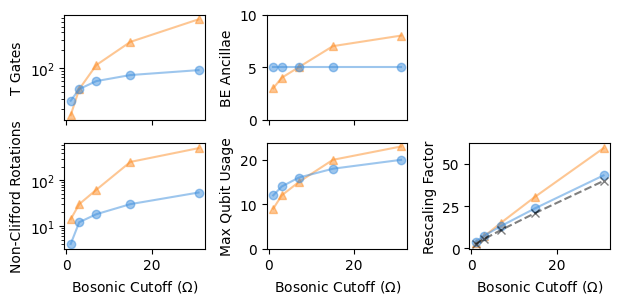

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(16 / 2.54, 8 / 2.54))

axes[0][0].plot(omegas, [(4*LCU_DATA[i][0].number_of_elbows) + LCU_DATA[i][0].number_of_t_gates for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5)
axes[0][0].plot(omegas, [(4*LOBE_DATA[i][0].number_of_elbows) + LOBE_DATA[i][0].number_of_t_gates for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5)
axes[0][0].set_ylabel("T Gates")
axes[0][0].set_xticklabels([])
axes[0][0].set_yscale("log")

axes[1][0].plot(omegas, [LCU_DATA[i][0].number_of_nonclifford_rotations for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][0].plot(omegas, [LOBE_DATA[i][0].number_of_nonclifford_rotations for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5)
axes[1][0].set_ylabel("Non-Clifford Rotations")
axes[1][0].set_xlabel("Bosonic Cutoff ($\Omega$)")
axes[1][0].set_yscale("log")

axes[0][1].plot(omegas, [LCU_DATA[i][2] for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5)
axes[0][1].plot(omegas, [LOBE_DATA[i][2] for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5)
axes[0][1].set_ylabel("BE Ancillae")
axes[0][1].set_xticklabels([])
axes[0][1].set_yticks([0, 5, 10])

axes[1][1].plot(omegas, [LCU_DATA[i][0].ancillae_highwater() + LCU_DATA[i][2] + LCU_DATA[i][3] + 1 for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5, label="LCU")
axes[1][1].plot(omegas, [LOBE_DATA[i][0].ancillae_highwater() + LOBE_DATA[i][2] + LCU_DATA[i][3] + 1 for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5, label="LOBE")
axes[1][1].set_ylabel("Max Qubit Usage")
axes[1][1].set_xlabel("Bosonic Cutoff ($\Omega$)")
axes[1][1].set_yticks([0, 10, 20])

axes[1][2].plot(omegas, [LCU_DATA[i][1] for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][2].plot(omegas, [LOBE_DATA[i][1] for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5)
axes[1][2].plot(omegas, [operator_norms[i] for i in range(len(omegas))], color="black", marker='x', ls='--', alpha = 0.5)
axes[1][2].set_ylabel("Rescaling Factor")
axes[1][2].set_xlabel("Bosonic Cutoff ($\Omega$)")

fig.delaxes(axes[0][2])
plt.tight_layout()
# axes[2][0].legend(loc='upper center', bbox_to_anchor=(1.5, 0.75),
#           fancybox=True, shadow=True, ncol=1)
plt.savefig("static_yukawa.pdf", dpi=300)